# SETUP: GLOBALS AND GENERAL UTILS

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [88]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'C'
second_order = 0
save = True
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [4]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,JQGS01000037_19,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,JQGS01000037_20,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037,1789,1757,JQGS01000065_1_2,100.00,33,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAATCCG,3,2,2,INTERGENIC,NULL,NULL,2,0.090909,middle
100053.4,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,JQGS01000037_36,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,JQGS01000037_38,UNCLASSIFIED,12,1.000000,tail


In [5]:
def seq_iter(filehandle):
    for seq_id in filehandle:
        yield seq_id.strip()[1:], next(filehandle).strip()
spacers = seq_iter(open(data_folder + 'all_spacers.fna.hits'))
all_seq = pd.DataFrame(spacers, 
                     columns=['spacer_id', 'seq'])
all_seq.head()

,spacer_id,seq
0,JQGS01000134_1_2,TGTCATAGATTCGGACAAAACAATTGCTTTTAC
1,JQGS01000134_1_3,GAATTCACCGGAGGGCCTGACGAAGATTCACAA
2,JQGS01000134_1_4,GTATTTTTCAATGATTATCTTTATGGATTCAGG
3,JQGS01000134_1_5,GGCGGATATAATTTGAAGATGAGTAACATTGAA
4,JQGS01000065_1_1,GATCATTTCTTTATTCTCTGCGAGGAGCATAT


In [6]:
df_genome_class = pd.read_csv(data_folder + 'genome.types.tsv', sep='\t', 
                              names=['genome_id', 'type', 'class', 'num_genes'], 
                              dtype={'genome_id': str, 'num_genes': int}).set_index('genome_id')
df_genome_class.head()

,type,class,num_genes
genome_id,,,
100053.4,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11
100053.5,CAS-TypeIE,SingleUnknownExtra,8
100053.6,CAS-TypeIE,SingleUnknownExtra,8
100053.7,CAS-TypeIE,SingleUnknownExtra,8
100053.8,CAS-TypeIE,AccompaniedSingleUnknown,8


In [7]:
df_crispr = pd.read_csv(data_folder + 'spacers.info.tsv', sep='\t', 
                        names=['contig', 'array_id', 'start', 'end', 'ori', 'size', 'type', 'conf', 'repeat',],
                               keep_default_na=False)
df_crispr.head()

,contig,array_id,start,end,ori,size,type,conf,repeat
1324264.3,JLXT01000011,JLXT01000011_1,0,684,Reverse,9,NA,3.18,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000009,JLXT01000009_1,947496,948851,Reverse,18,NA,3.24,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000010,JLXT01000010_1,56,1186,Reverse,15,NA,3.20,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1603886.3,BDIS01000038,BDIS01000038_1,5412,6343,Forward,14,NA,3.24,CAAGCTTATCAAGAAGGGTGAATGCTAATTCCCAGC
1633637.3,CZVQ01000157,CZVQ01000157_1,2,778,Forward,9,NA,3.26,GTGAGCATCGAACCAGTGTGGAATTTAAAC


# PATCHES AND ENHANCEMENTS
Other patches that have been applied can be found in the patches folder. (The summary contains all (and more) in one file.) To apply just `bash ../patches/summary` in the data/folder.

In [8]:
df = df.reset_index().merge(all_seq, how='left', on='spacer_id', validate='m:1').set_index('genome_id')

### Remove uninteresting duplicates

In [9]:
# Duplicates resulting from duplicates contigs (same spacer_id with same coords on different contig.)
# This will also remove duplicates genomes
df = df.reset_index().groupby(['spacer_id', 'c_1', 'c_2']).first().reset_index().set_index('genome_id')
# Remove double arrays (same seq, same hit, same array location)
df = df.reset_index().groupby(['seq', 'c_1', 'c_2', 'contig_hit', 'spacer_pos']).first().reset_index().set_index('genome_id')

In [10]:
total_genomes = 110334
no_type = total_genomes - len(df_genome_class)  # There is also NOCAS in all_genome_types which is basically the same.
no_cas_no_selfhits = total_genomes - len(set(df.index)) - no_type  # Because of the above, this number is not correct.

In [11]:
# Identity with hit cut-off
df_all = df
perc_ident = 90
df = df.query('hit_ident > %d' % perc_ident)
perc_ident = '100%' if perc_ident == 100 else '>%d%%' % perc_ident

# TRYING TO MAKE CRISPR GROUPING

## DEFAULT GROUPING

In [13]:
df_single_type = df[~df['genome_type'].str.contains('/')]

In [14]:
import re
def megasplit(pattern, string):
    """Split with zero lenght
    https://stackoverflow.com/questions/29988595/python-regex-splitting-on-pattern-match-that-is-an-empty-string
    """
    splits = list((m.start(), m.end()) for m in re.finditer(pattern, string))
    starts = [0] + [i[1] for i in splits]
    ends = [i[0] for i in splits] + [len(string)]
    return [string[start:end] for start, end in zip(starts, ends)]

def sort_groups(group_type):
    if group_type == 'other':
        return 'MZ'
    if not group_type.startswith("CAS"):
        return "Z" + group_type
    return "-".join(megasplit(r'(?<=V|I)(?!V|I)', group_type))

In [15]:
df_genome = df.groupby(df.index).first()
df_genome['selfhit_count'] = df.groupby(df.index)['contig_hit'].agg('count')
df_genome_type_count = df_genome['genome_type'].value_counts()
all_genome_type_count = df_genome_class['type'].value_counts()
all_genome_type_count = all_genome_type_count[df_genome_type_count.index]
all_genome_type_count['NOCAS'] = no_type
all_genome_type_count['other'] = total_genomes - sum(all_genome_type_count)
df_genome_type_count['other'] = 0
df_genome_type_count = df_genome_type_count.reindex(index = sorted(df_genome_type_count.index))
all_genome_type_count = all_genome_type_count.reindex(index = sorted(all_genome_type_count.index))

In [16]:
all_genome_type_count

CAS                  7869.0
CAS-TypeI               9.0
CAS-TypeIA            148.0
CAS-TypeIA/B           19.0
CAS-TypeIA/B/C          1.0
CAS-TypeIA/B/D          8.0
CAS-TypeIA/C          251.0
CAS-TypeIA/C/U          1.0
CAS-TypeIA/D            7.0
CAS-TypeIA/U            2.0
CAS-TypeIB           2397.0
CAS-TypeIB/C          833.0
CAS-TypeIB/D            9.0
CAS-TypeIB/E            6.0
CAS-TypeIB/U            6.0
CAS-TypeIC           2397.0
CAS-TypeIC/D            3.0
CAS-TypeIC/E           90.0
CAS-TypeIC/E/F          8.0
CAS-TypeIC/F           88.0
CAS-TypeID            180.0
CAS-TypeIE          16074.0
CAS-TypeIE/F          218.0
CAS-TypeIE/U           20.0
CAS-TypeIF           4089.0
CAS-TypeIIA          2851.0
CAS-TypeIIA/C          58.0
CAS-TypeIIB           205.0
CAS-TypeIIB/C           5.0
CAS-TypeIIC          2983.0
CAS-TypeIII            52.0
CAS-TypeIIIA        10041.0
CAS-TypeIIIA/B         16.0
CAS-TypeIIIA/B/D        7.0
CAS-TypeIIIA/C          3.0
CAS-TypeIIIA/D      

## CUSTOM GROUPING

In [17]:
def new_type_group(row):
#     print(row)
    if row['num_genes'] == 0:
        return "NOCAS"
    if "Unclassified" in row['class']:
        return "Uncomplete"
    if "MultipleConfirmed" in row['class']:
        return "Confirmed Mixed"
    if "/" in row['type'] or row['type'] == "CAS": 
        return "Mixed"
    return row['type']
#     if "Confirmed" in row['class']:
#         return "Confirmed " + row['type']
#     if "Accompanied" in row['class']:
#         return "Accompanied " + row['type']
    
df_genome_class['new_type_group'] = df_genome_class.apply(new_type_group, axis=1)

In [19]:
df = df.join(df_genome_class)
df_genome_class[['new_type_group']].head()

,new_type_group
genome_id,
100053.4,CAS-TypeIE
100053.5,CAS-TypeIE
100053.6,CAS-TypeIE
100053.7,CAS-TypeIE
100053.8,CAS-TypeIE


In [22]:
alltypes_renamed_count = df_genome_class['new_type_group'].value_counts()
dftyped_renamed = df.groupby(by='genome_id').first()
dftyped_renamed['selfhit_count'] = df.groupby(by='genome_id')['contig_hit'].agg('count')
dftyped_renamed_count = dftyped_renamed['new_type_group'].value_counts()
print(alltypes_renamed_count)
alltypes_renamed_count = alltypes_renamed_count[dftyped_renamed_count.index]
alltypes_renamed_count['NOCAS'] += no_type
other = 'other'  # *can* include: {'CAS-TypeVC': 1, 'CAS-TypeVIB2': 2}
alltypes_renamed_count[other] = total_genomes - sum(alltypes_renamed_count)
dftyped_renamed_count[other] = 0
dftyped_renamed_count = dftyped_renamed_count.reindex(index=sorted(dftyped_renamed_count.index, key=sort_groups))
alltypes_renamed_count = alltypes_renamed_count.reindex(index=sorted(alltypes_renamed_count.index, key=sort_groups))

CAS-TypeIE         15342
CAS-TypeIIIA       10035
Uncomplete          5627
CAS-TypeIF          3390
NOCAS               3035
CAS-TypeIIC         2983
CAS-TypeIIA         2844
CAS-TypeIC          2384
CAS-TypeIB          2341
Mixed               2033
Confirmed Mixed      683
CAS-TypeIU           262
CAS-TypeIIIB         250
CAS-TypeIIB          205
CAS-TypeIV           189
CAS-TypeIIID         155
CAS-TypeIA           135
CAS-TypeID           107
CAS-TypeVA            71
CAS-TypeVIA           53
CAS-TypeVIB1          34
CAS-TypeVB            15
CAS-TypeIIIC          12
CAS-TypeVIB2           2
CAS-TypeVC             1
Name: new_type_group, dtype: int64


In [23]:
alltypes_renamed_count

CAS-TypeIA           135
CAS-TypeIB          2341
CAS-TypeIC          2384
CAS-TypeID           107
CAS-TypeIE         15342
CAS-TypeIF          3390
CAS-TypeIU           262
CAS-TypeIIA         2844
CAS-TypeIIB          205
CAS-TypeIIC         2983
CAS-TypeIIIA       10035
CAS-TypeIIIB         250
CAS-TypeIIIC          12
CAS-TypeIIID         155
CAS-TypeIV           189
CAS-TypeVA            71
CAS-TypeVB            15
CAS-TypeVIA           53
CAS-TypeVIB1          34
other                  3
Confirmed Mixed      683
Mixed               2033
NOCAS              61181
Uncomplete          5627
Name: new_type_group, dtype: int64

In [24]:
def insert_rows(df, idx, df_insert=None):
    if not df_insert: 
        df_insert = [0] * len(idx)
    df_insert = [pd.Series({"": i}) for i in df_insert]
    res = df.iloc[:idx[0], ]
    for i in range(len(idx) - 1):
        res = res.append(df_insert[i]).append(df.iloc[idx[i]:idx[i+1], ])
    res = res.append(df_insert[-1]).append(df.iloc[idx[-1]:, ])
    return res

# splits = [7, 10, 14, 15, 18, 21]
splits = [7, 10, 14, 15, 17, 19, 22]
dftyped_renamed_count = insert_rows(dftyped_renamed_count, splits)
alltypes_renamed_count = insert_rows(alltypes_renamed_count, splits)

# Top level plotting (Of STS in groups "NOCAS", "Uncomplete", "Mixed", "System")

In [25]:
df['top_level_group'] = df['new_type_group'].apply(lambda x: 'Mixed' if 'Mixed' in x else 
                                                  {k: k for k in ['NOCAS', 'Uncomplete']}.get(x) or 'CRISPR-Type')

# PLOTTING

### Change what grouping to use for coming plots

In [27]:
custom = True
if custom:
    df_genome_type_count = dftyped_renamed_count
    all_genome_type_count = alltypes_renamed_count
all_genome_type_count

CAS-TypeIA           135
CAS-TypeIB          2341
CAS-TypeIC          2384
CAS-TypeID           107
CAS-TypeIE         15342
CAS-TypeIF          3390
CAS-TypeIU           262
                       0
CAS-TypeIIA         2844
CAS-TypeIIB          205
CAS-TypeIIC         2983
                       0
CAS-TypeIIIA       10035
CAS-TypeIIIB         250
CAS-TypeIIIC          12
CAS-TypeIIID         155
                       0
CAS-TypeIV           189
                       0
CAS-TypeVA            71
CAS-TypeVB            15
                       0
CAS-TypeVIA           53
CAS-TypeVIB1          34
                       0
other                  3
Confirmed Mixed      683
Mixed               2033
                       0
NOCAS              61181
Uncomplete          5627
dtype: int64

Text(0.5, 1.0, 'Distribution of types of all genomes')

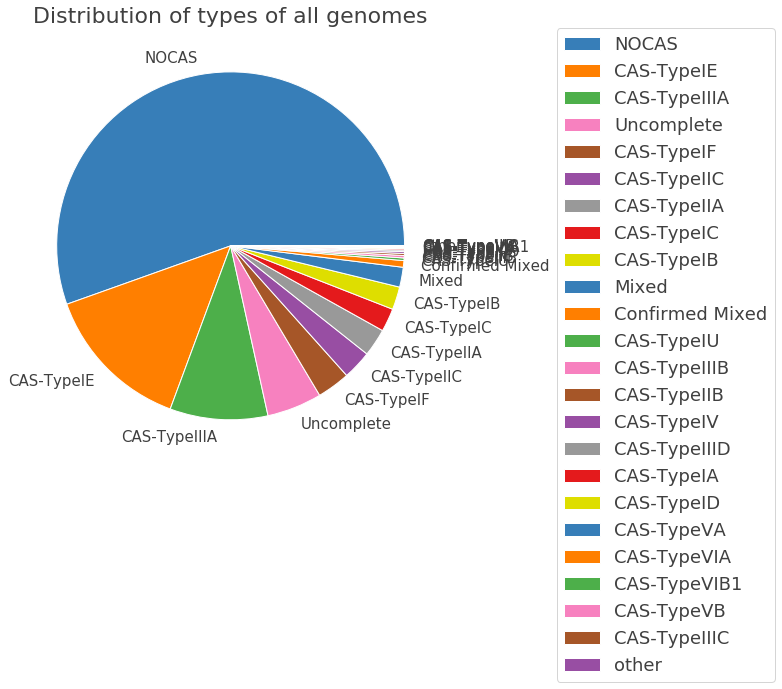

In [28]:
ax = all_genome_type_count[all_genome_type_count != 0].sort_values(ascending=False).plot.pie(legend=True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
increase_figsize(2, plt)
ax.set_ylabel("")
ax.set_title("Distribution of types of all genomes")
# save_fig()

In [29]:
# ax = sns.countplot(x='spacer_size', data=df, color=cbf[0], saturation=100)
# # increase_figsize(3, plt)

# sns.despine()
# every_nth = 5
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if (n-1) % every_nth != 0:
#         label.set_visible(False)
# # ax.set_yscale('log')
# plt.title("Spacer size (all spacer hits)" + title_mod)
# plSize = plt.gcf().get_size_inches()
# plt.gcf().set_size_inches( (plSize[0]*1, plSize[1]*2) )
# if save:
#     second_order += 1
#     plt.savefig(fig_folder + first_order + str(second_order) + ax.get_title().replace(" ", "_") + ".png", format='png', bbox_inches='tight')

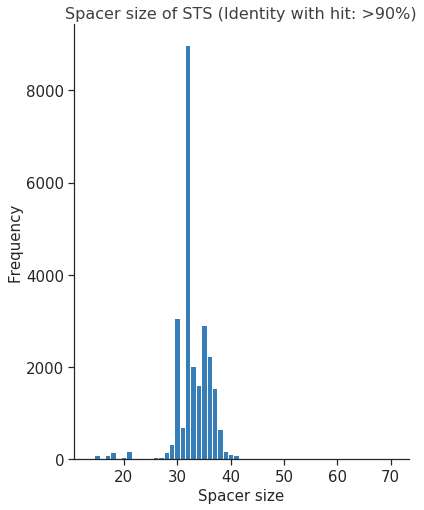

In [31]:
ax = df['spacer_size'].hist(bins=list(map(.5 .__rsub__, range(df['spacer_size'].min(), df['spacer_size'].max() + 2))))
sns.despine()
ax.grid(False)
plSize = plt.gcf().get_size_inches()
plt.gcf().set_size_inches((plSize[0]*1, plSize[1]*2))
# ax.set_yscale('log')
plt.title("Spacer size of STS (Identity with hit: %s)" % perc_ident + title_mod, fontsize=16)
plt.xlabel("Spacer size")
plt.ylabel("Frequency")
save_fig()

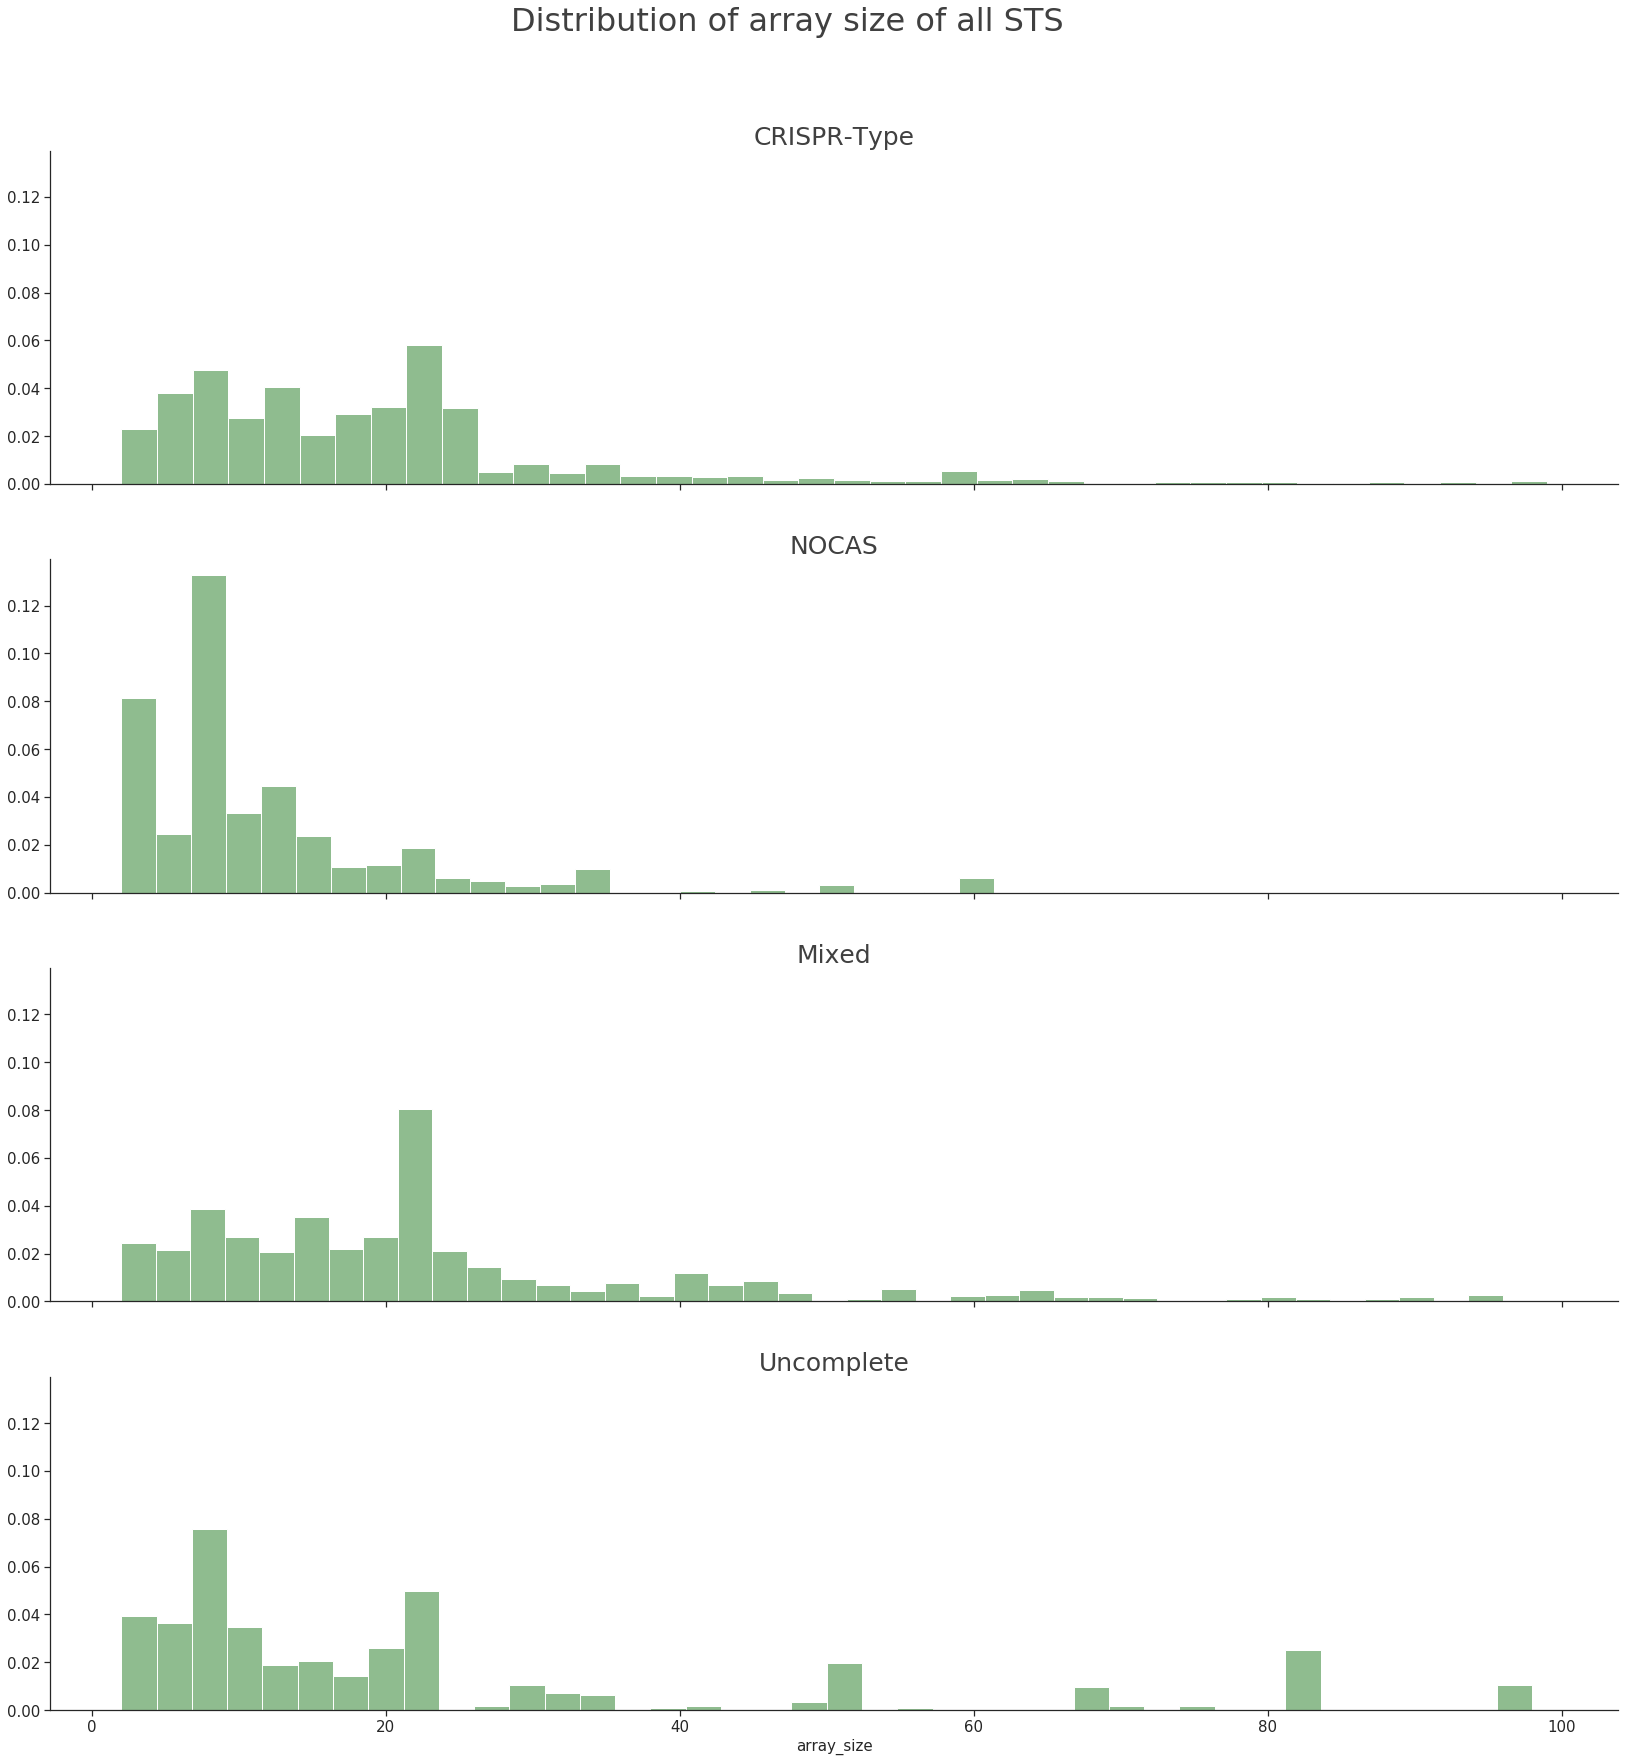

In [32]:
g = df.query('array_size < 100').pipe(sns.FacetGrid, row='top_level_group', aspect=4, ) 
g = g.map(plt.hist, 'array_size', density=True, color='darkseagreen', bins=40)
g.set_titles(row_template="{row_name}", fontsize=25)
g.fig.suptitle("Distribution of array size of all STS", fontsize=32, y=1.05)
# ax.set_yscale('log')
increase_figsize(2, plt)
save_fig(g)

True


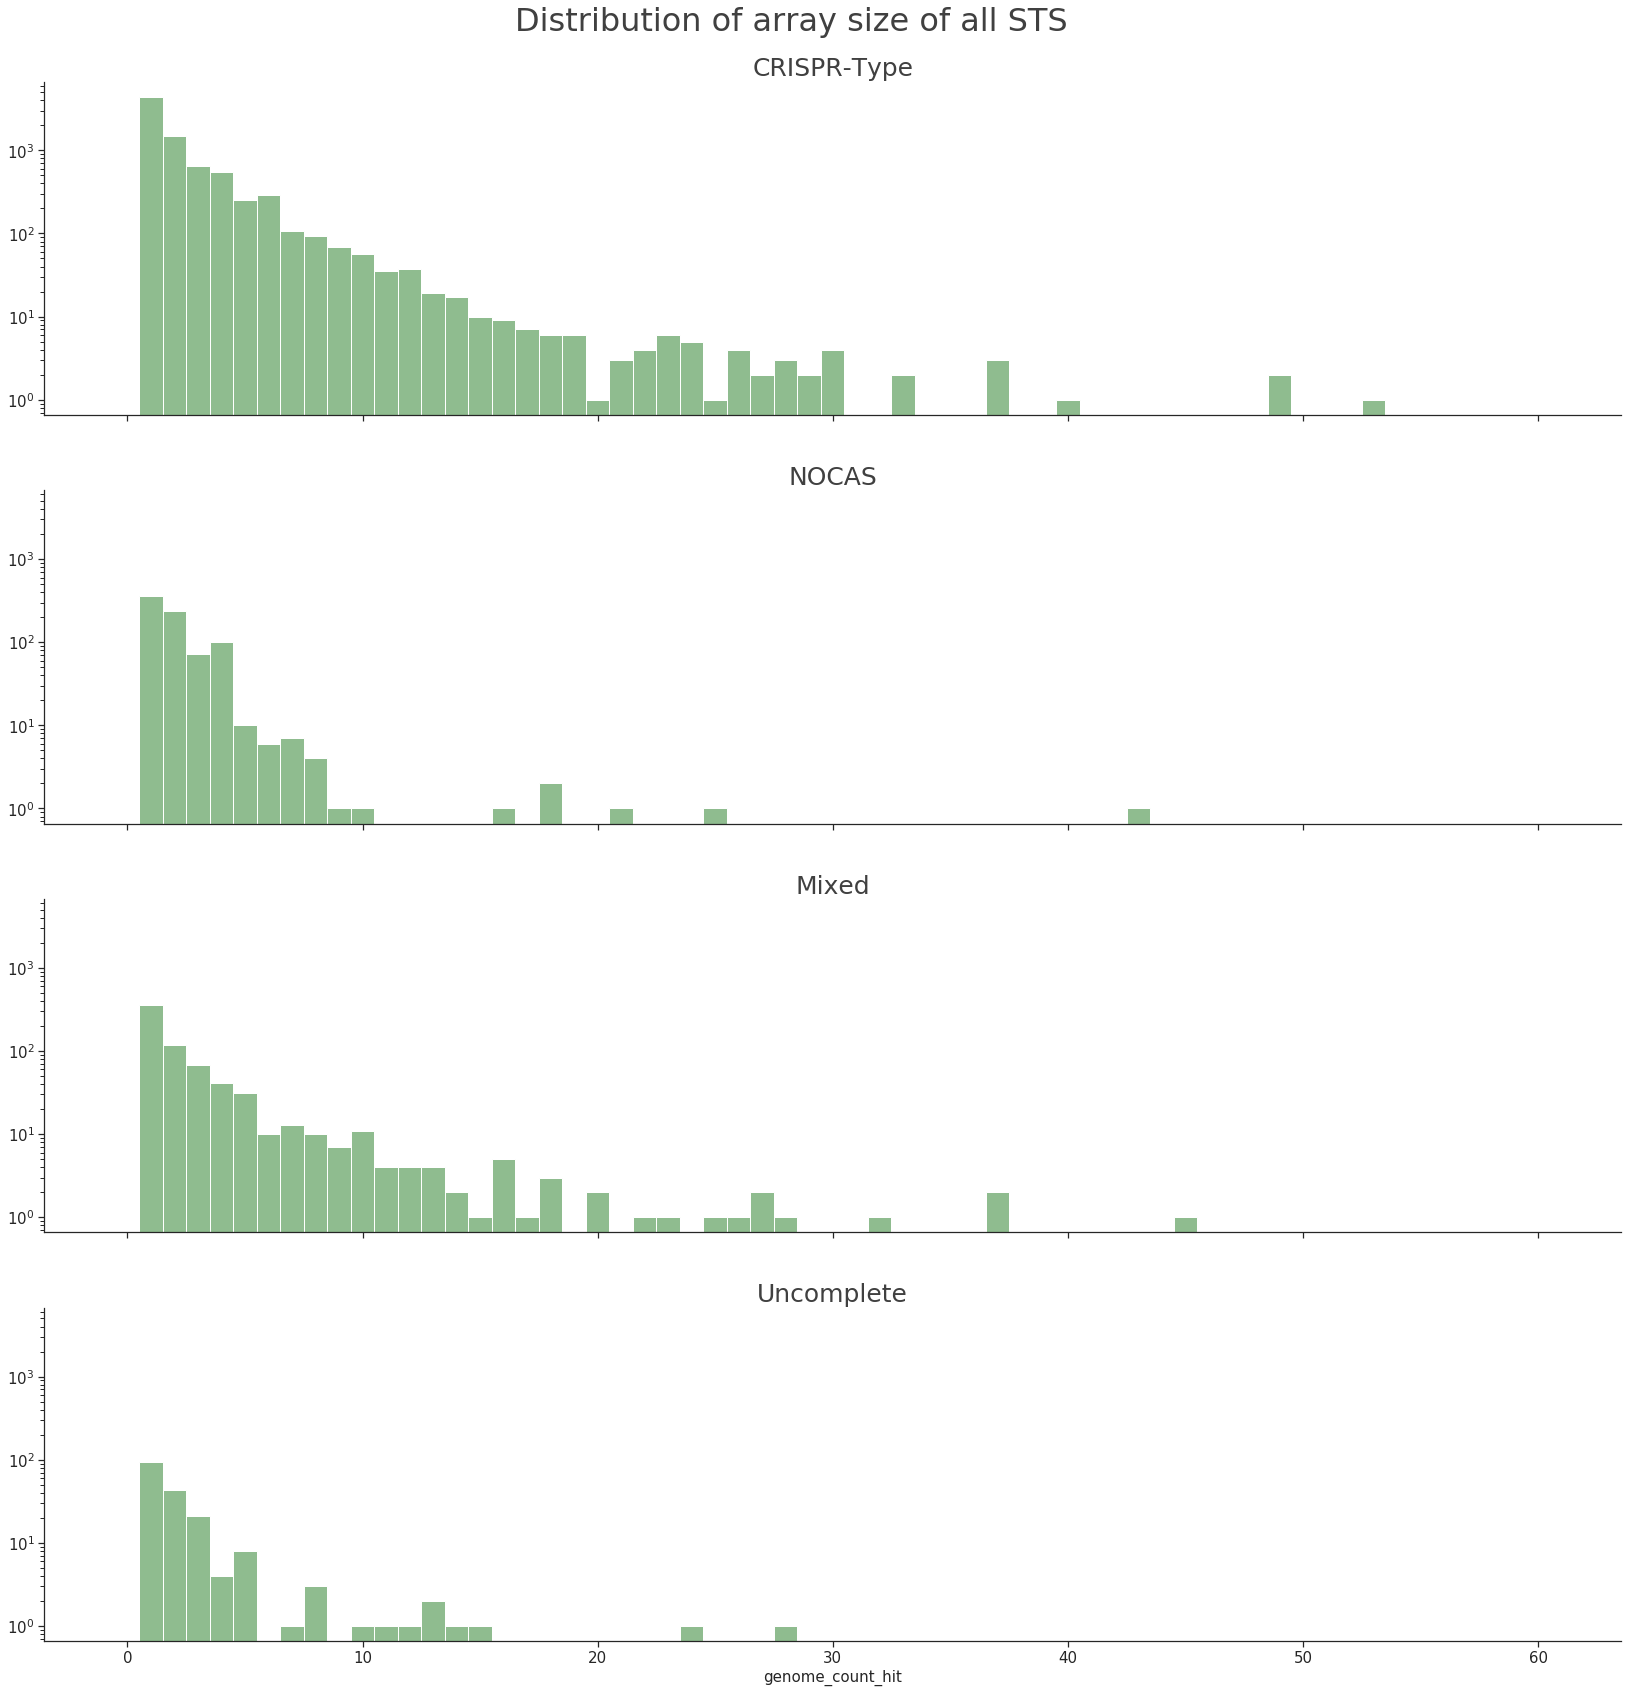

In [87]:
max_hit_count = 60

df_hitcount = df.groupby(by='genome_id').first()
df_hitcount['genome_count_hit'] = df.groupby(by='genome_id')['array_id'].agg('count')

g = df_hitcount.query('genome_count_hit < %d' % max_hit_count).pipe(sns.FacetGrid, row='top_level_group', aspect=4, ) 
g = g.map(plt.hist, 'genome_count_hit', density=False, color='darkseagreen', 
          bins=list(map(.5 .__rsub__, range(0, max_hit_count + 2))))
g.set_titles(row_template="{row_name}", fontsize=25)
g.fig.suptitle("Distribution of array size of all STS", fontsize=32, y=1.01)
g.set(yscale='log')
increase_figsize(2, plt)
save_fig(g)

In [34]:
all_genome_type_count[all_genome_type_count.index != 'NOCAS']

CAS-TypeIA           135
CAS-TypeIB          2341
CAS-TypeIC          2384
CAS-TypeID           107
CAS-TypeIE         15342
CAS-TypeIF          3390
CAS-TypeIU           262
                       0
CAS-TypeIIA         2844
CAS-TypeIIB          205
CAS-TypeIIC         2983
                       0
CAS-TypeIIIA       10035
CAS-TypeIIIB         250
CAS-TypeIIIC          12
CAS-TypeIIID         155
                       0
CAS-TypeIV           189
                       0
CAS-TypeVA            71
CAS-TypeVB            15
                       0
CAS-TypeVIA           53
CAS-TypeVIB1          34
                       0
other                  3
Confirmed Mixed      683
Mixed               2033
                       0
Uncomplete          5627
dtype: int64

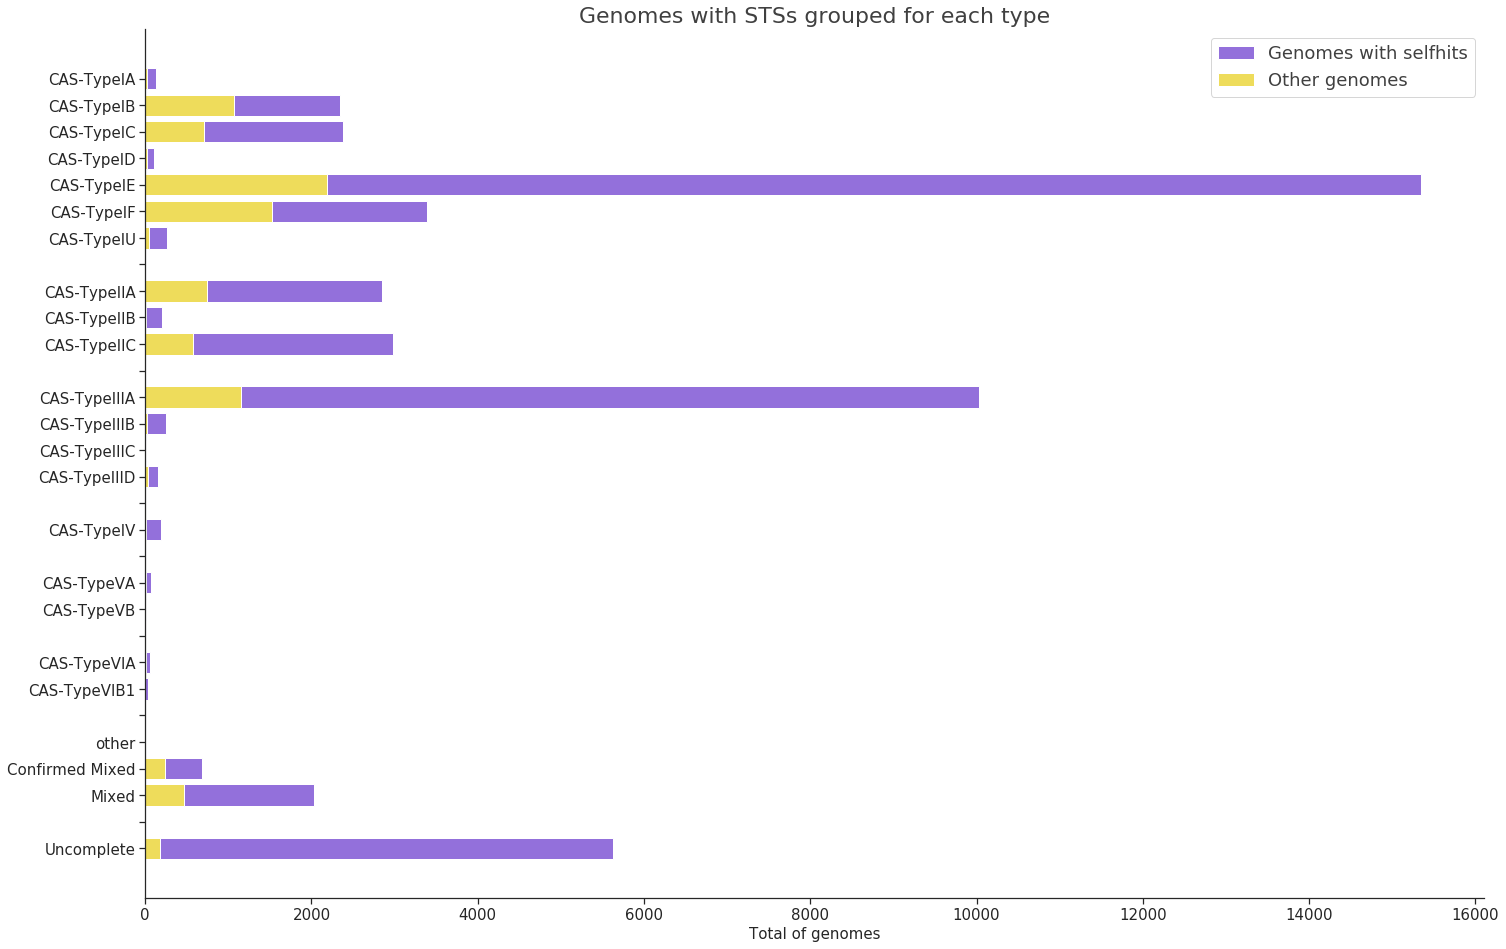

In [35]:
df_genome_type_count_subsection = df_genome_type_count[df_genome_type_count.index != 'NOCAS']
all_genome_type_count_subsection = all_genome_type_count[all_genome_type_count.index != 'NOCAS']

N = len(df_genome_type_count_subsection)

ind = list(range(N))[::-1]

plt.barh(ind, all_genome_type_count_subsection, color='mediumpurple', )
ax = plt.barh(ind, df_genome_type_count_subsection, color=sns.xkcd_rgb["dull yellow"], )

plt.yticks(ind, df_genome_type_count_subsection.index)
plt.legend(['Genomes with selfhits', 'Other genomes'], loc='upper right')
plt.title("Genomes with STSs grouped for each type")
plt.xlabel("Total of genomes")
# plt.gca().set_xscale('log')
sns.despine()
increase_figsize(4, plt, )
if save: 
    second_order += 1
    plt.savefig(fig_folder + first_order + str(second_order) + "Genomes with STSs grouped for each type".replace(" ", "_") + ".png", format='png', bbox_inches='tight')

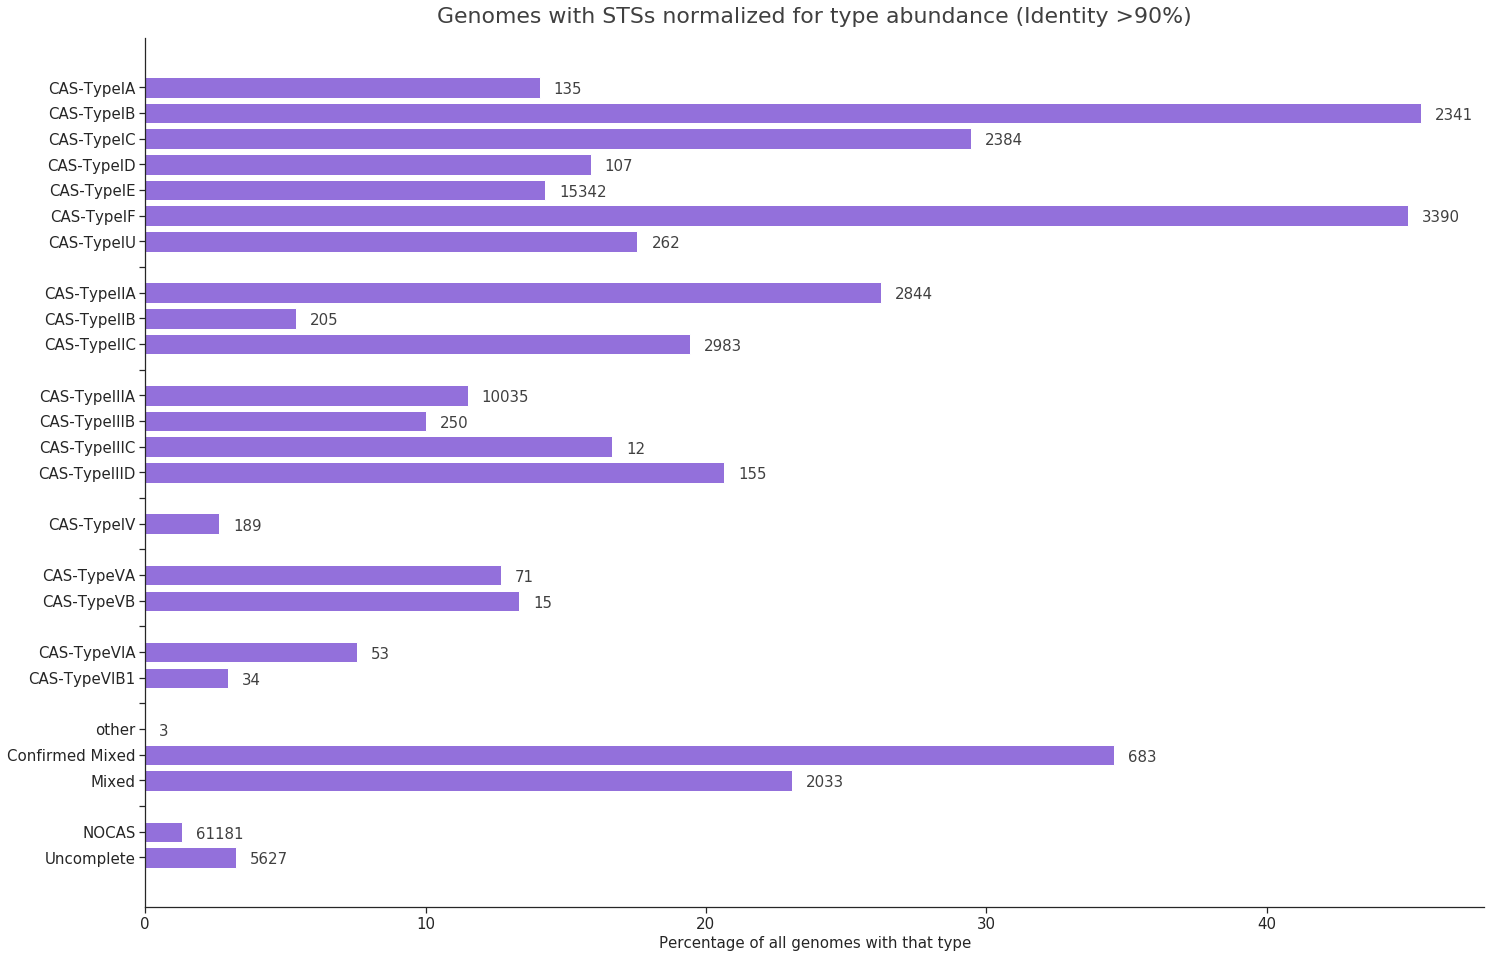

In [36]:
color="mediumpurple"
value_counts_perc = [(p / w * 100) if p != 0 else 0 for p, w in zip(df_genome_type_count, all_genome_type_count)]
N = len(df_genome_type_count)
ind = list(range(N))[::-1]
fig, ax = plt.subplots()    
plt.barh(ind, value_counts_perc, color=color)
plt.yticks(ind, df_genome_type_count.index)
for i, v in enumerate(all_genome_type_count):
#     print(v)
#     print(str(round(v)))
    if v == 0: continue
    ax.text(value_counts_perc[i]+0.5, ind[i]-0.25, str(round(v)), color='0.25', fontsize=15)
plt.title("Genomes with STSs normalized for type abundance (Identity %s)" % perc_ident, y=1.01)
plt.xlabel("Percentage of all genomes with that type")
sns.despine()
increase_figsize(4, plt)
save_fig()

# PHAGE HIT

In [37]:
df_phage_retyped = df.groupby(by='genome_id').first()
df_phage_retyped['phage_perc'] = df.groupby(by='genome_id')['with_phage'].agg(lambda x: sum(x==2)/len(x))

df_phage_retyped.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,type,class,num_genes,new_type_group,top_level_group,phage_perc
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10514,10484,JQGS01000075,2,JQGS01000093_1_2,96.875,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CCTTTATGGA,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type,0.833333
100053.5,CACATCCAACCCGAAGACTTGAGCATTCTTCA,1242,1273,JQGU01000091,22,JQGU01000025_1_22,100.000,32,16908,JQGU01000025_1,23,6.23,29,CAS-TypeIE,CAS-TypeIE,0,CTGGTTGGTG,3,NULL,0,RNA-,JQGU01000091_1,Protein of unknown function (DUF1564),0.954545,middle,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,CRISPR-Type,0.000000
100053.6,GAGACAGATTCGAAGGAAACTTCAAAGACGAC,11287,11256,JQGV01000052,38,JQGV01000216_1_38,100.000,32,18548,JQGV01000216_1,51,6.26,29,CAS-TypeIE,CAS-TypeIE,0,CGTTCTTATA,3,NULL,0,RNA-,JQGV01000052_10,MORN motif,0.740000,middle,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,CRISPR-Type,0.000000
100053.7,AAAACAGAATGGATTTTGACTTAAAACCCTAACCACTAATTCCTAA...,5644,5589,JQGT01000055,24,JQGT01000117_1_24,91.070,56,5671,JQGT01000117_1,24,6.16,29,CAS-TypeIE,CAS-TypeIE,3,CCATTCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,CRISPR-Type,0.117647
100053.8,AAAACAGGATGGATTTTGATTTAAAACCCTAACCACTGATTCCTAA...,146,200,JQGW01000033,3,JQGW01000031_1_3,98.180,55,75992,JQGW01000031_1,3,5.25,29,CAS-TypeIE,CAS-TypeIE,3,CCATCCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,CAS-TypeIE,AccompaniedSingleUnknown,8,CAS-TypeIE,CRISPR-Type,0.000000


Code below raises warning, but can't be fixed because of: 

https://github.com/pandas-dev/pandas/issues/18366

Check this link when the code below breaks to see the alternative syntax implemented in the pull request that will close the issue. 

/home/hielke/pydev/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


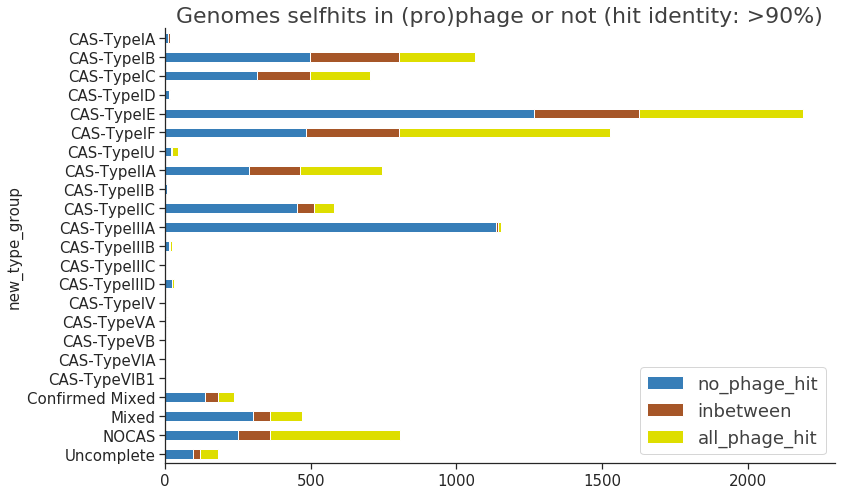

In [38]:
phage_hit_genome_level = df_phage_retyped.groupby("new_type_group") \
        ['phage_perc'].agg({"all_phage_hit": lambda x: sum(x==1.0), 
                                                                       "inbetween": 'count', 
                                                                       "no_phage_hit": lambda x: sum(x==0.0),
                                                                      })
phage_hit_genome_level['inbetween'] = phage_hit_genome_level['inbetween'] \
                                    - phage_hit_genome_level['all_phage_hit'] \
                                    - phage_hit_genome_level['no_phage_hit']
phage_hit_genome_level = phage_hit_genome_level.reindex(sorted(phage_hit_genome_level.index, key=sort_groups, reverse=True))
phage_hit_genome_level.plot.barh(stacked=True, cmap=cbf_map)
sns.despine()
plt.title("Genomes selfhits in (pro)phage or not (hit identity: %s)" % perc_ident)
increase_figsize(2, plt)
save_fig()

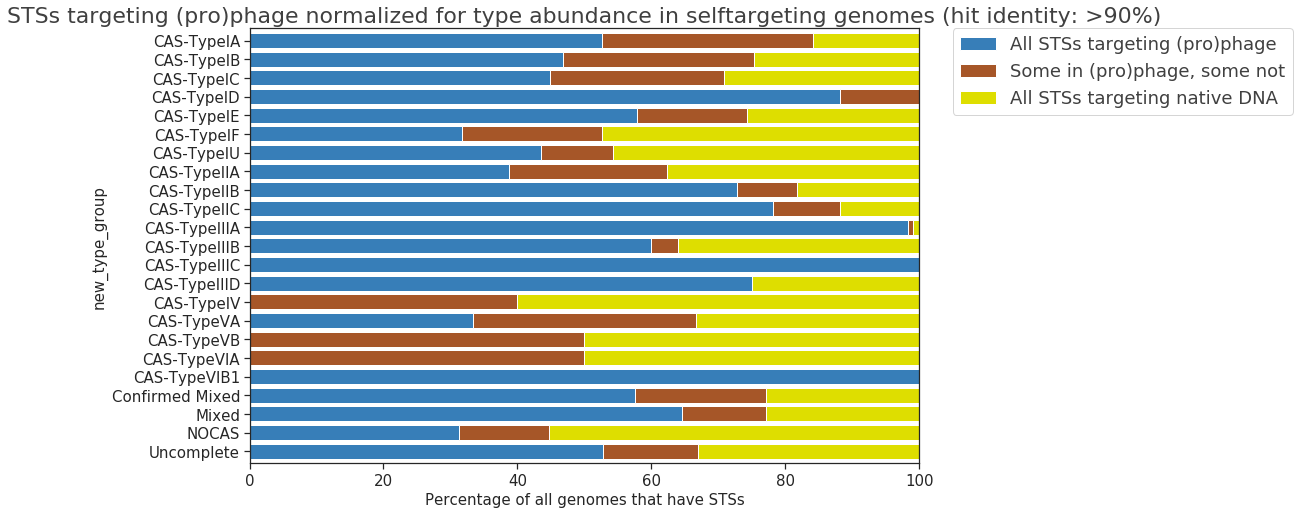

In [39]:
phage_hit_genome_level_percentage = phage_hit_genome_level.div(phage_hit_genome_level.sum(axis=1), axis=0).mul(100)
phage_hit_genome_level_percentage.plot.barh(stacked=True, cmap=cbf_map, width=.8)
plt.gca().legend(loc='center right',  shadow=True)
plt.gca().set_xlim((0, 100))
plt.legend(['All STSs targeting (pro)phage', 'Some in (pro)phage, some not', 'All STSs targeting native DNA'], 
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STSs targeting (pro)phage normalized for type abundance in selftargeting genomes (hit identity: %s)" 
          % perc_ident)
plt.xlabel("Percentage of all genomes that have STSs")
increase_figsize(2, plt)
save_fig()

# PLOTTING

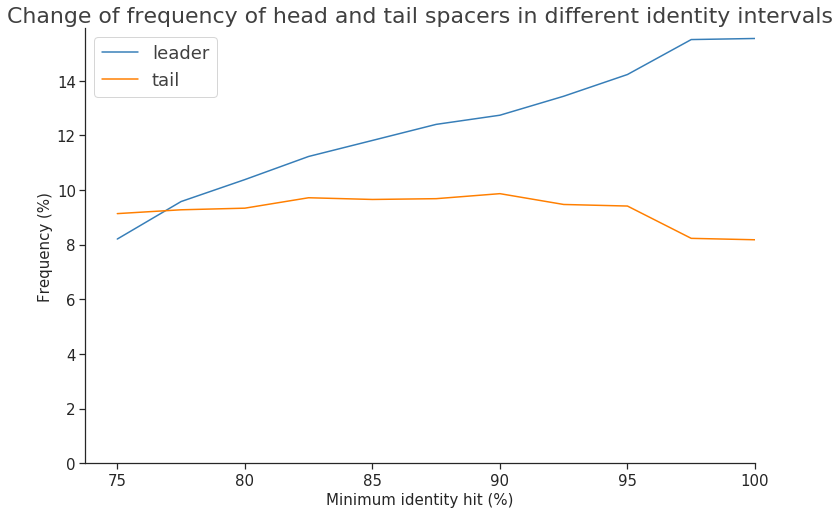

In [40]:
# Cumulative sum to have each range till 100 %
# For each group the percentage of that group is displayed.
def percentage(x): return x / x.sum()

df_all_cut = pd.cut(df_all['hit_ident'], 10)
pivot_table = (df_all.groupby(['name_spacer_pos', df_all_cut]).size() 
        .groupby(level=0).apply(lambda x: x[::-1].cumsum()[::-1]) 
        .groupby(level=1).apply(percentage) 
        .unstack(0).fillna(0)
              )

# pd.core.base.PandasObject.reverse = lambda df: df.reindex(index=df.index[::-1])

# sum_ranges = (df_all.groupby(df_all_cut).size()
#               .reverse().cumsum().reverse()
#              )
pivot_table.index = pivot_table.index.map(lambda x: round(x.left, 1)).astype(float)

# Finish table with the group with exactly 100 % identity
pivot_table = pivot_table.append(
    df_all.query('hit_ident == 100')
    .groupby('name_spacer_pos').size()
    .pipe(percentage)
    .to_frame(100.0).T
)

pivot_table = pivot_table * 100

ax = sns.lineplot(data=pivot_table.drop('middle', axis=1), dashes=False)
sns.despine()
plt.legend(loc='upper left')
ax.set_ylim(bottom=0)
ax.set_xlim(right=100)
ax.set_xlabel('Minimum identity hit (%)')
ax.set_ylabel('Frequency (%)')
ax.set_title('Change of frequency of head and tail spacers in different identity intervals')
increase_figsize(2)
save_fig()

Text(0.5, 1.0, 'Spacer position (all spacer hits)')

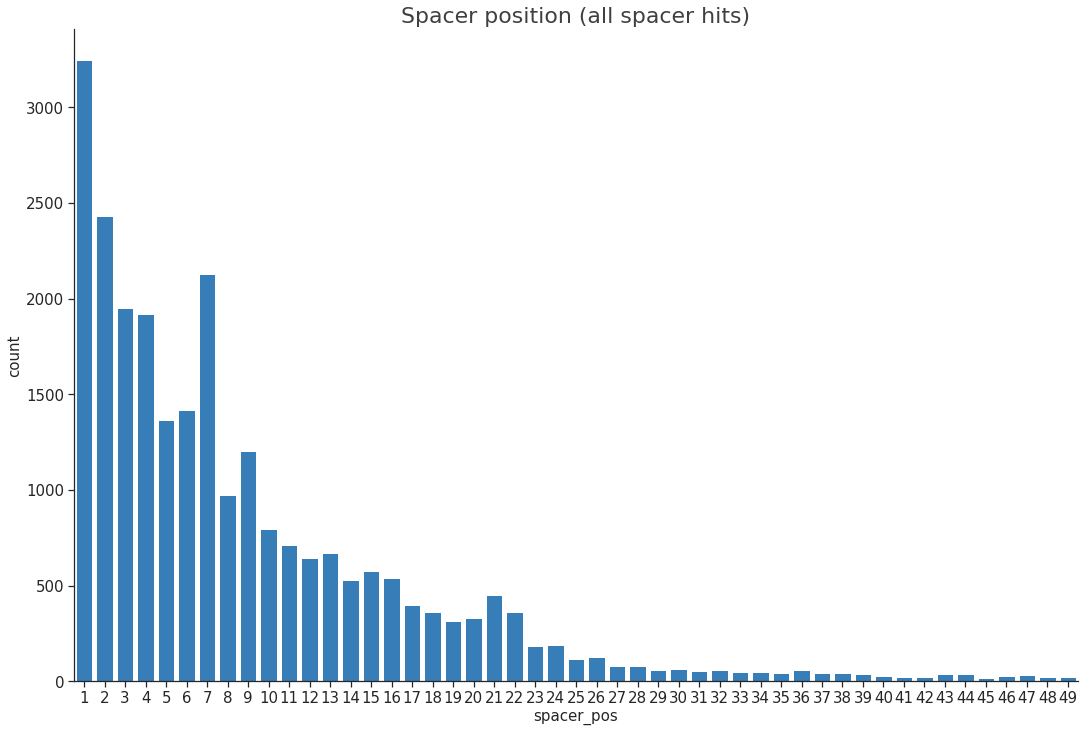

In [41]:
ax = sns.countplot(x='spacer_pos', data=df.query('spacer_pos < 50'), color=cbf[0], saturation=100)
increase_figsize(3, plt)
sns.despine()
plt.title("Spacer position (all spacer hits)" + title_mod)
# save_fig()

Text(0.5, 1.0, 'Spacer position reversed (all spacer hits)')

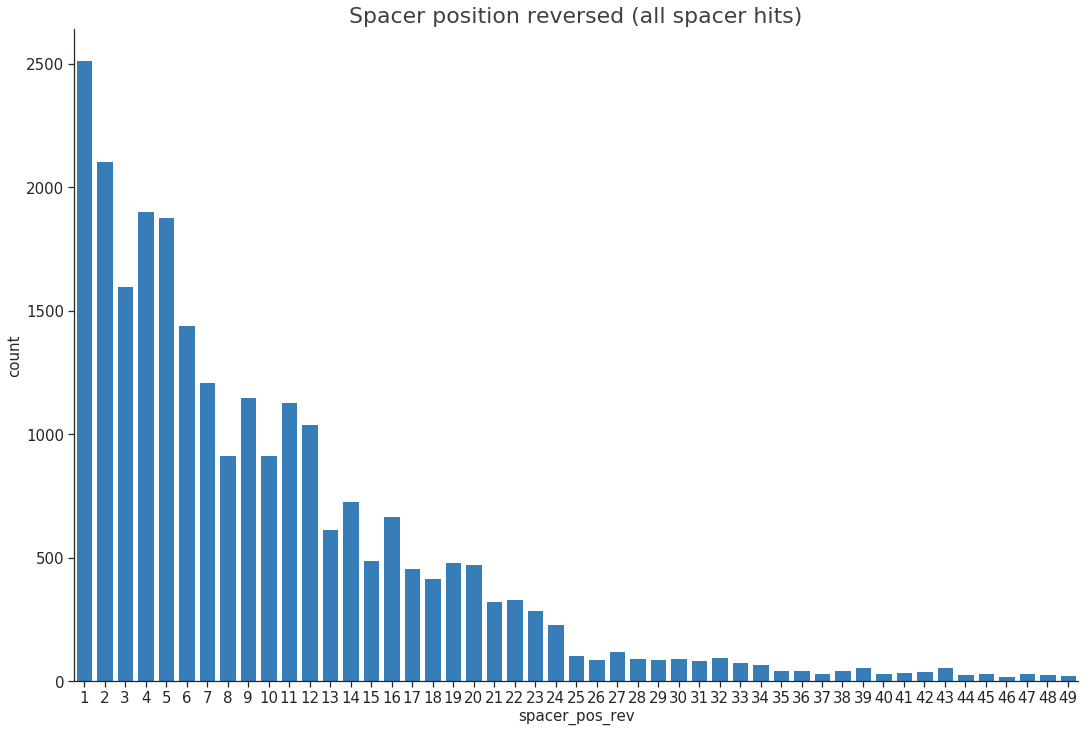

In [43]:
# spacer position reversed
df = df.assign(spacer_pos_rev=df['array_size'].add(1).subtract(df['spacer_pos']))
ax = sns.countplot(x='spacer_pos_rev', data=df.query('spacer_pos_rev < 50'), color=cbf[0], saturation=100)
increase_figsize(3, plt)
sns.despine()
plt.title("Spacer position reversed (all spacer hits)" + title_mod)
# save_fig()

Text(0.5, 1.0, 'Relative spacer position (all spacer hits); 0: leader; 1: tail')

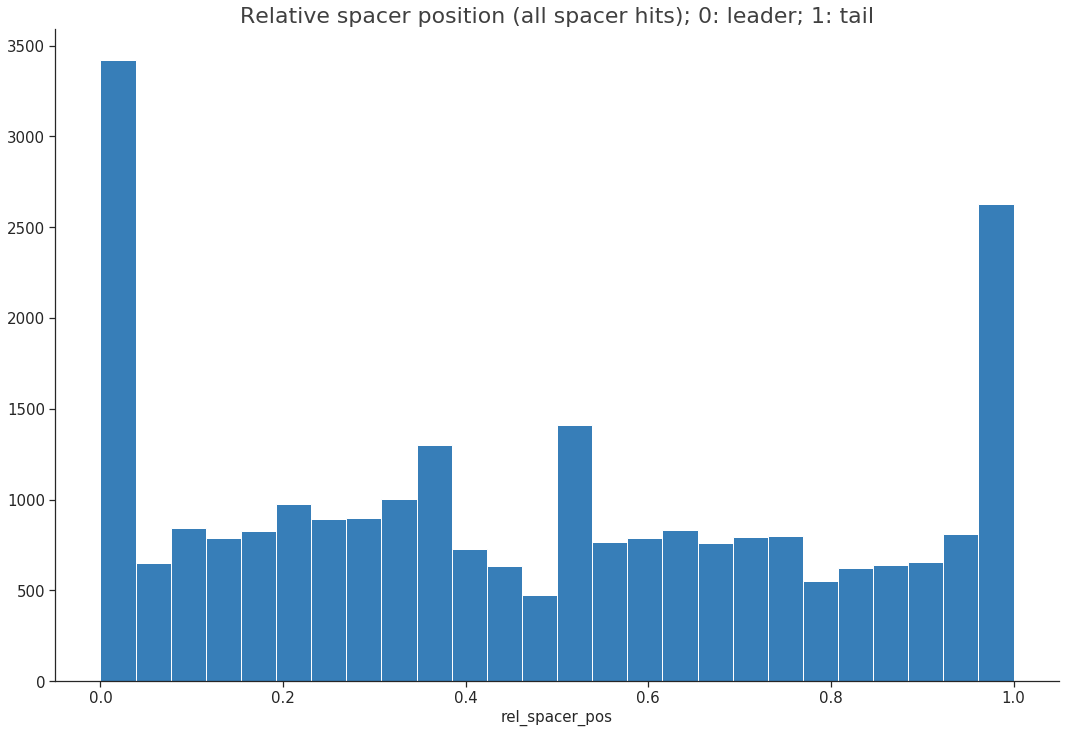

In [44]:
ax = sns.distplot(df['rel_spacer_pos'], kde=False, hist_kws={'color': cbf[0], 'alpha': 1})
increase_figsize(3, plt)
sns.despine()
plt.title("Relative spacer position (all spacer hits); 0: leader; 1: tail" + title_mod)
# save_fig()

[None, None]

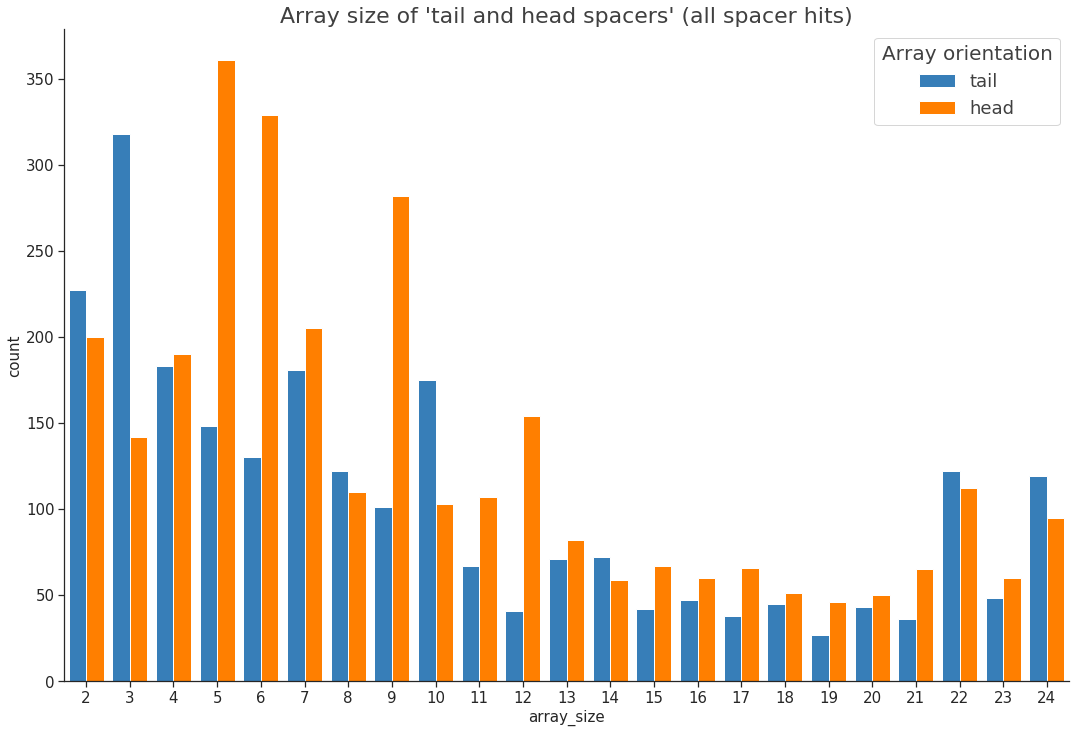

In [45]:
# relative spacer position
df['array_ori'] = df['rel_spacer_pos'].apply(lambda x: 'mid' if {0: 'head', 1: 'tail'}.get(x) is None else {0: 'head', 1: 'tail'}.get(x))
ax = sns.countplot(x = 'array_size', data=df.query('array_ori != "mid" and array_size < 25'), 
                   hue='array_ori', saturation=100, palette=cbf)
increase_figsize(3, plt)
sns.despine()
plt.title("Array size of 'tail and head spacers' (all spacer hits)" + title_mod)
plt.setp(ax.get_legend().get_title(), fontsize=20, text="Array orientation")
# save_fig()

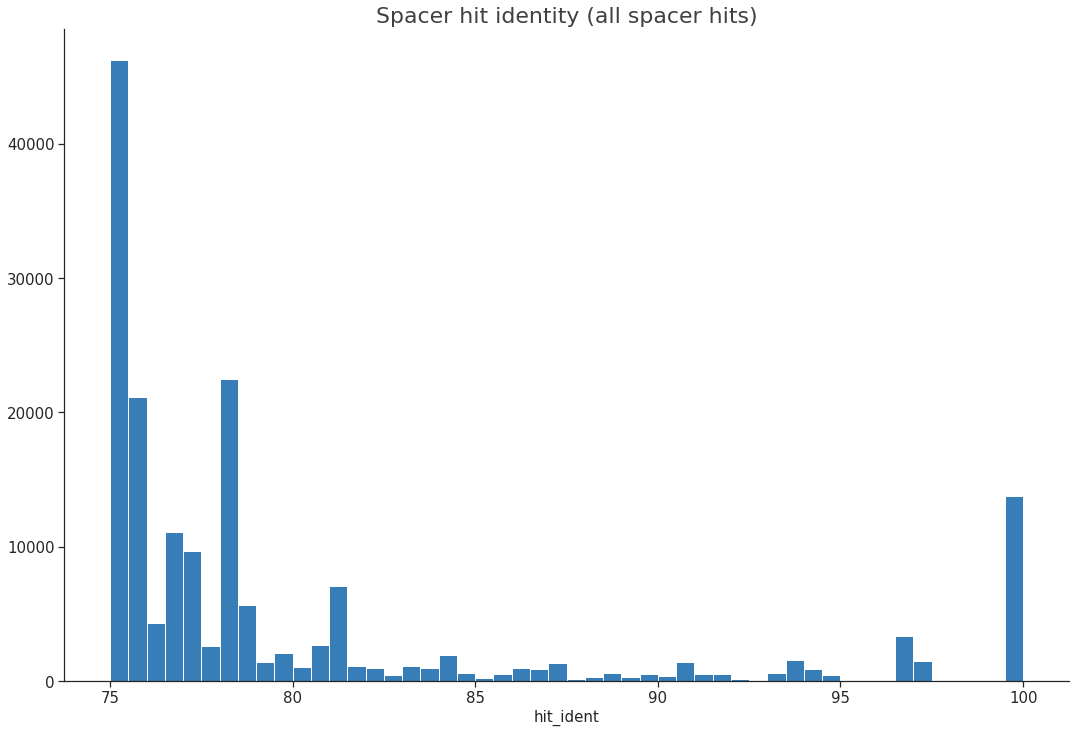

In [46]:
df_all['hit_ident'] = pd.to_numeric(df_all['hit_ident'])
ax = sns.distplot(df_all['hit_ident'], kde=False, hist_kws={'color': cbf[0], 'alpha': 1})
increase_figsize(3, plt)
sns.despine()
plt.title("Spacer hit identity (all spacer hits)" + title_mod)
save_fig()

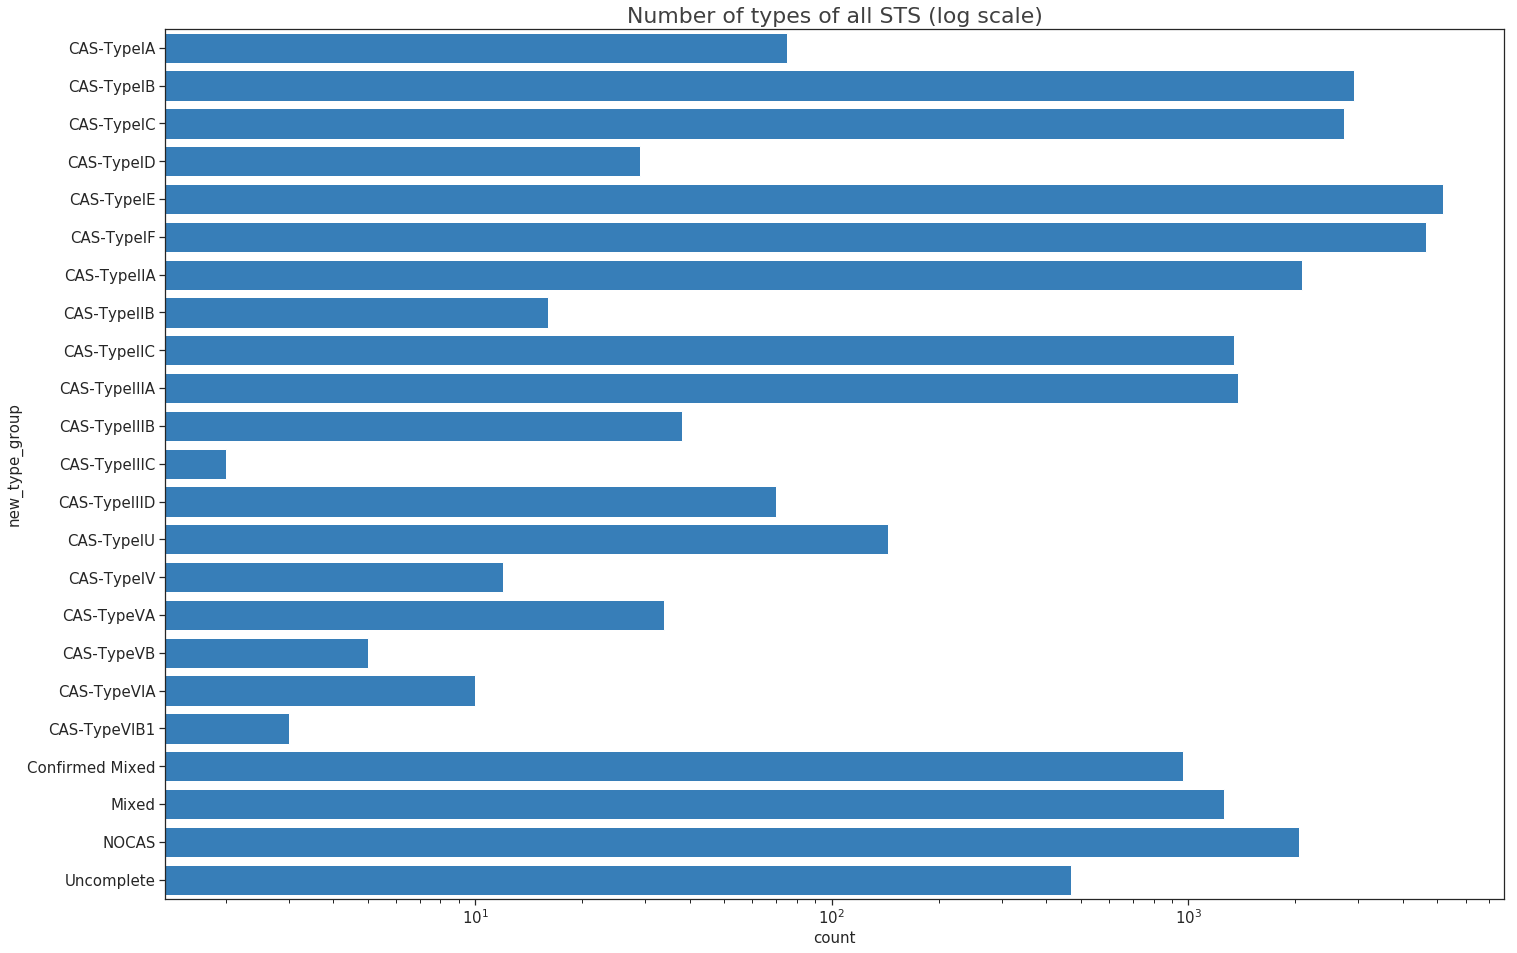

In [47]:
ax = sns.countplot(y='new_type_group', data=df, color=cbf[0], saturation=100, order=sorted(df['new_type_group'].unique()))
ax.set_xscale('log')
increase_figsize(4, plt)
plt.title("Number of types of all STS (log scale)" + title_mod)
save_fig()

Text(0.5, 1.0, 'Number of single types of all STS(log scale)')

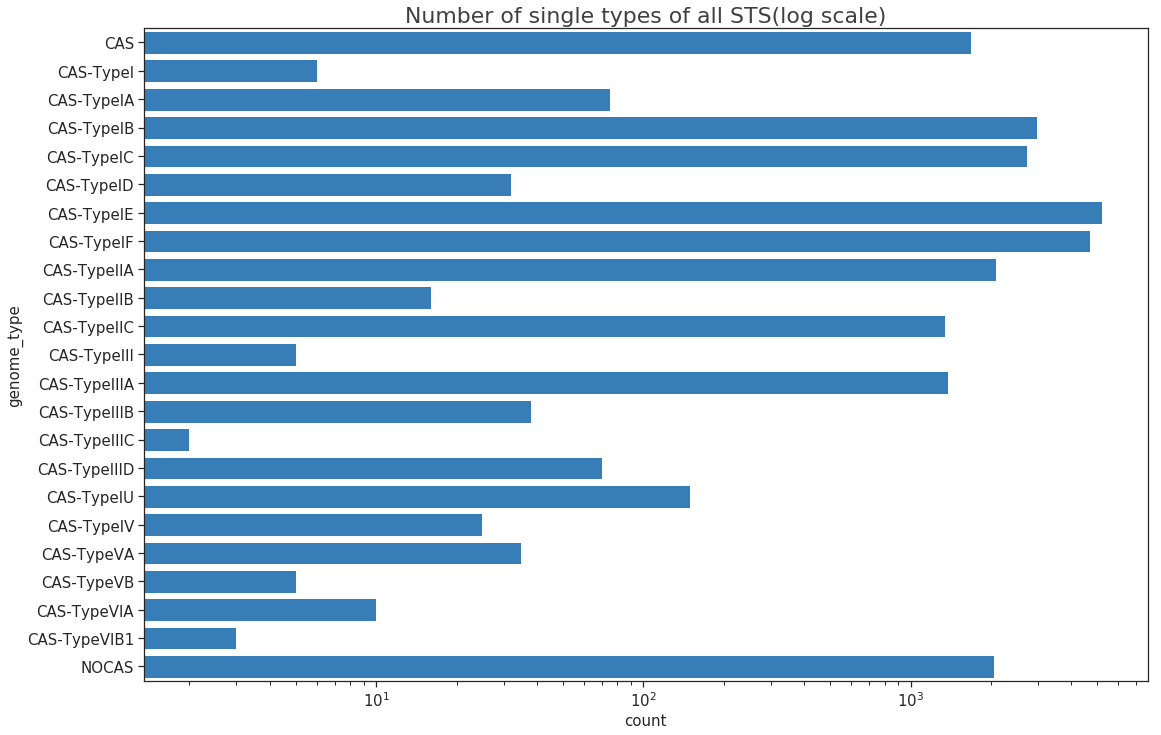

In [48]:
ax = sns.countplot(y='genome_type', data=df_single_type, color=cbf[0], saturation=100, order=sorted(df_single_type['genome_type'].unique()))
ax.set_xscale('log')
increase_figsize(3)
plt.title("Number of single types of all STS(log scale)" + title_mod)
# save_fig()

In [49]:
pivot_table = df_single_type.groupby(['genome_type', pd.cut(df_single_type['hit_ident'], 10)]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table

hit_ident,"(89.991, 91.001]","(91.001, 92.001]","(92.001, 93.001]","(93.001, 94.001]","(94.001, 95.001]","(95.001, 96.001]","(96.001, 97.0]","(97.0, 98.0]","(98.0, 99.0]","(99.0, 100.0]"
genome_type,,,,,,,,,,
CAS,4.937537,6.008328,1.725164,6.186794,7.138608,0.297442,8.625818,8.744795,0.059488,56.276026
CAS-TypeI,0.000000,16.666667,0.000000,0.000000,16.666667,0.000000,0.000000,66.666667,0.000000,0.000000
CAS-TypeIA,10.666667,6.666667,2.666667,0.000000,18.666667,0.000000,0.000000,12.000000,0.000000,49.333333
CAS-TypeIB,0.100942,12.651413,3.633917,0.100942,15.948856,0.000000,0.201884,15.814266,0.000000,51.547779
CAS-TypeIC,2.301790,9.682134,0.767263,2.594081,7.563025,0.073073,5.078553,12.787724,0.036536,59.115820
CAS-TypeID,0.000000,6.250000,6.250000,0.000000,9.375000,0.000000,0.000000,15.625000,18.750000,43.750000
CAS-TypeIE,11.300517,0.861904,0.229841,12.162421,4.175445,0.325608,21.049607,0.670370,0.038307,49.185980
CAS-TypeIF,12.843450,0.127796,0.000000,13.993610,0.851970,0.000000,22.470714,0.851970,0.000000,48.860490
CAS-TypeIIA,2.869440,4.112865,0.095648,12.721186,5.930177,0.000000,17.599235,7.699665,0.000000,48.971784


Text(0.5, 1.0, 'Heatmap of identity with hit')

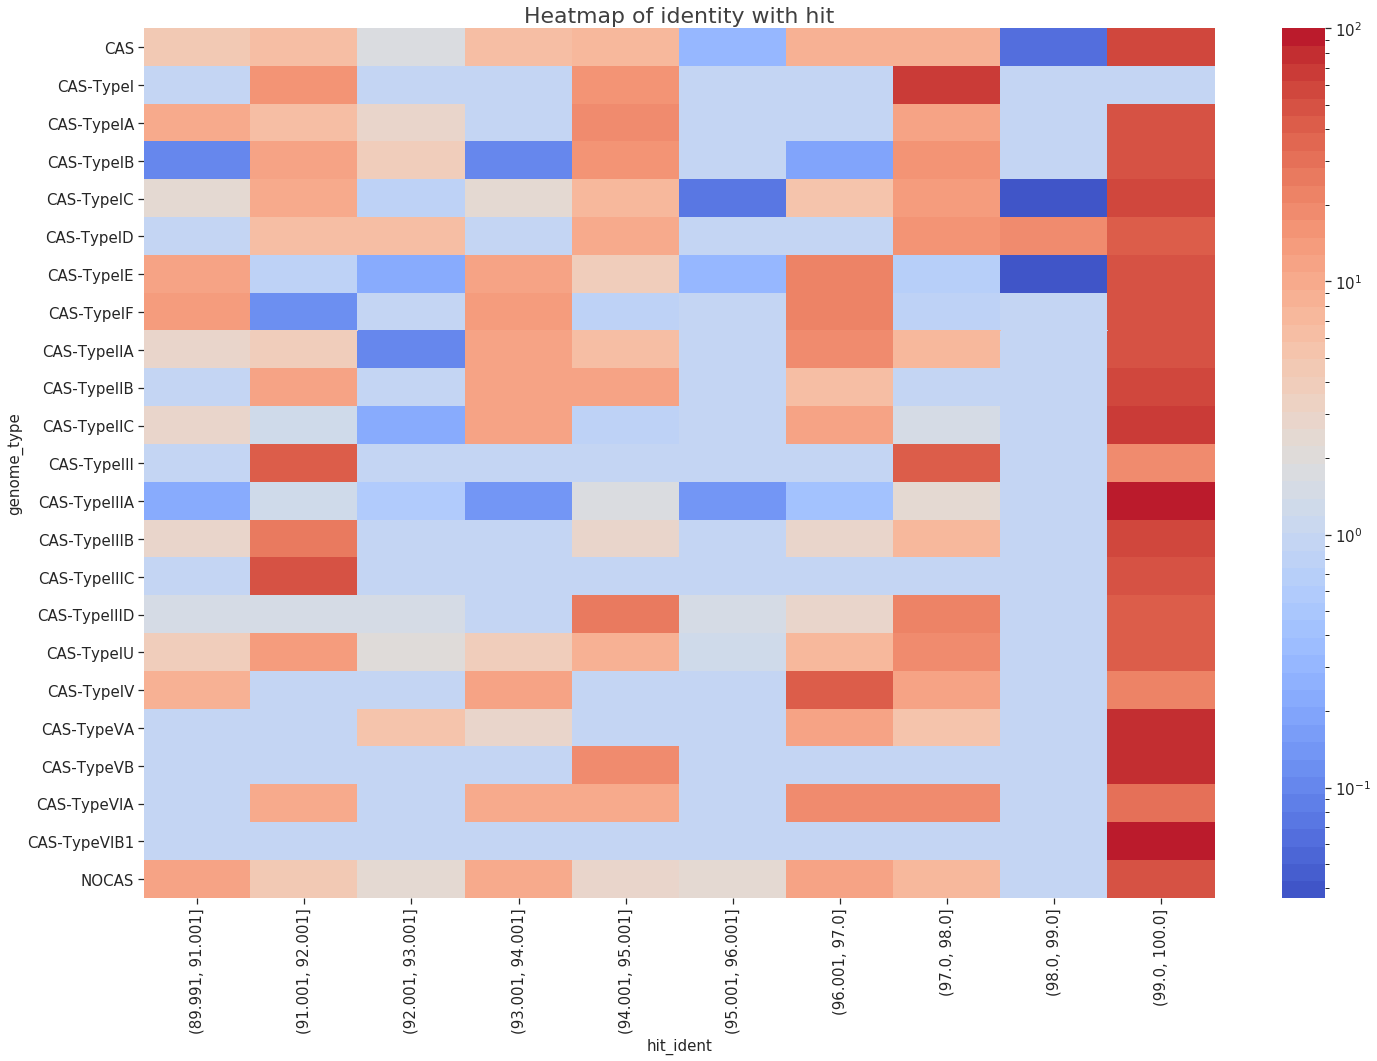

In [50]:
ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of identity with hit" + title_mod)
# save_fig()

In [51]:
pivot_table = df_single_type.groupby(
    ['genome_type', pd.cut(df_single_type['array_size'], 
    pd.IntervalIndex.from_breaks(list(range(0,80,5)) + [400]))]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table

array_size,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]","(55, 60]","(60, 65]","(65, 70]","(70, 75]","(75, 400]"
genome_type,,,,,,,,,,,,,,,,
CAS,7.733492,16.954194,12.849494,13.860797,19.809637,5.948840,3.331350,4.283165,3.033908,0.297442,1.487210,0.832838,1.130280,0.892326,0.713861,6.841166
CAS-TypeI,0.000000,16.666667,16.666667,33.333333,33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CAS-TypeIA,2.666667,22.666667,13.333333,10.666667,2.666667,0.000000,18.666667,4.000000,0.000000,13.333333,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
CAS-TypeIB,6.123822,20.491252,22.341857,11.137281,14.401077,6.796770,7.065949,2.119785,1.076716,1.547779,0.471063,3.600269,0.134590,0.874832,0.269179,1.547779
CAS-TypeIC,8.403361,15.235659,8.805261,12.166606,31.530873,3.470954,3.544026,2.740227,1.278772,1.315309,1.680672,1.388381,2.630617,0.803800,0.438436,4.567044
CAS-TypeID,6.250000,12.500000,56.250000,3.125000,3.125000,9.375000,0.000000,6.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.125000
CAS-TypeIE,10.591841,22.237119,18.597970,10.342846,20.360084,2.853859,2.873013,1.436506,2.030262,0.919364,0.555449,0.785290,1.283279,0.191534,0.727830,4.213752
CAS-TypeIF,14.227902,18.594249,9.627263,8.221512,40.660277,0.681576,1.618743,0.404686,0.298190,0.447284,0.234292,1.661342,0.809372,0.127796,0.149095,2.236422
CAS-TypeIIA,11.429938,27.068388,11.860354,10.951698,13.390722,5.882353,9.947394,2.821616,2.439024,0.860832,1.243424,0.813008,0.000000,1.099952,0.000000,0.191296


Text(0.5, 1.0, 'Heatmap of array size')

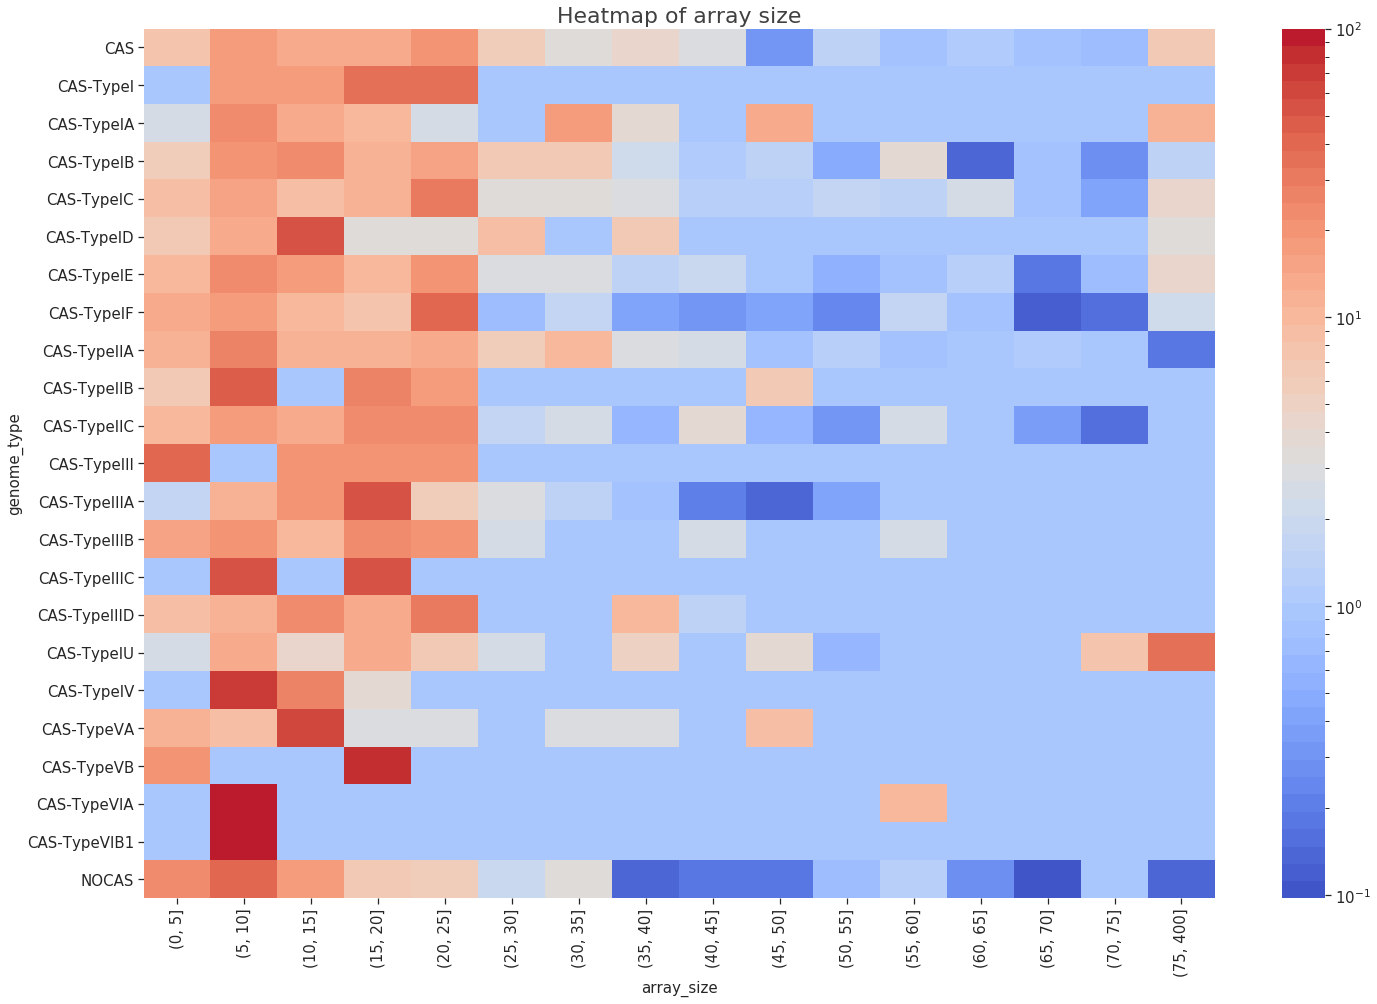

In [52]:
ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of array size" + title_mod)
# save_fig()

Text(0.5, 1.0, 'Heatmap of spacer position')

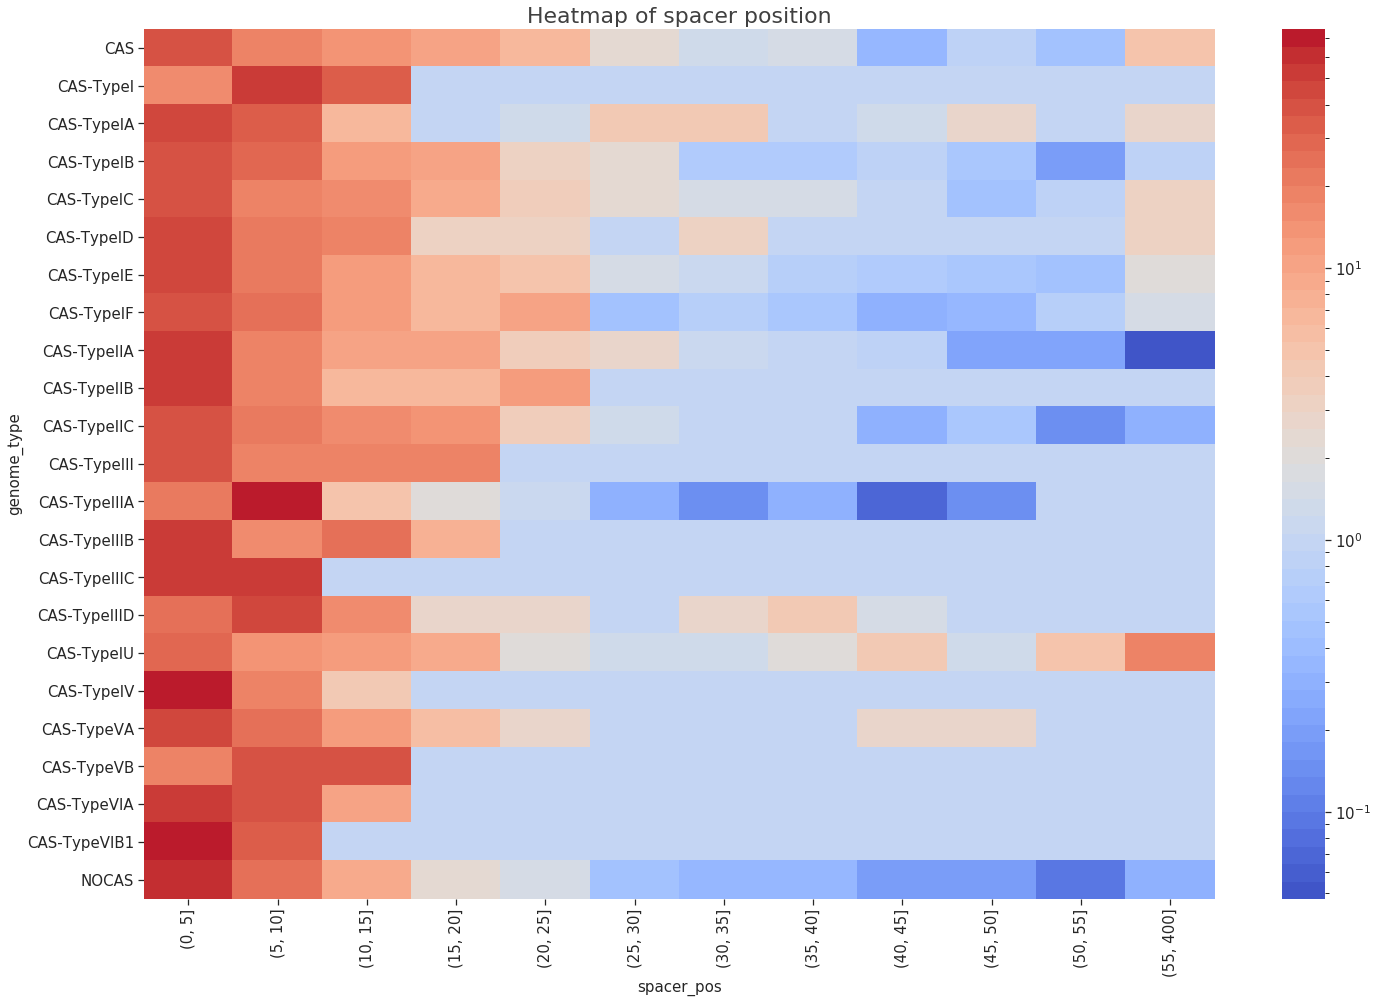

In [53]:
pivot_table = df_single_type.groupby(
    ['genome_type', pd.cut(df_single_type['spacer_pos'], 
    pd.IntervalIndex.from_breaks(list(range(0,60,5)) + [400]))]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table
ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of spacer position" + title_mod)
# save_fig()

In [54]:
# pivot_table = df_single_type.groupby(
#     ['genome_type', pd.cut(df_single_type['rel_spacer_pos'], 
#     pd.IntervalIndex.from_breaks(list(map(lambda x: -.01 if x==0 else round(0.01*x, 2), range(0,110,5)))))
#                            ]).size() \
#         .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
# pivot_table
# ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
#             cmap=sns.color_palette("coolwarm", 50), 
#             cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
#             norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
# increase_figsize(4, plt)
# plt.title("Heatmap of relative spacer position (0: leader; 1: tail)" + title_mod)
# if False or save: plt.savefig(fig_folder + first_order + str(second_order) + ax.get_title().replace(" ", "_") + ".png", format='png', bbox_inches='tight')

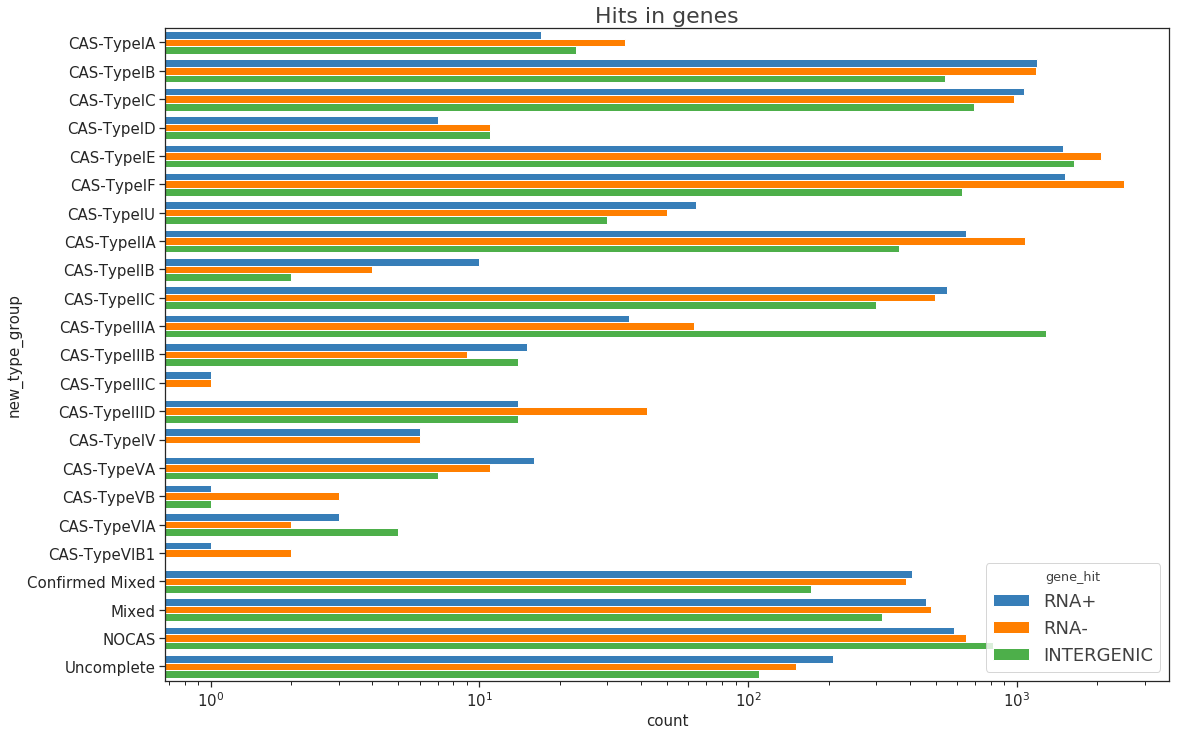

In [55]:
# df_single_type = df[~df['genome_type'].str.contains('/')]
ax = sns.countplot(y='new_type_group', hue='gene_hit', data=df, 
                   saturation=100, palette=cbf, order=sorted(df['new_type_group'].unique(), key=sort_groups))
ax.set_xscale('log')
increase_figsize(3)
plt.title("Hits in genes" + title_mod)
save_fig()